# BERT

BERT, Bidirectional Encoder Representatios from Transformers, é um outro tipo de modelo de representação de linguagem. Foi introduzido em 2018 pelo Google e seu artigo pode ser consultado aqui: [link](https://arxiv.org/pdf/1810.04805)

Três razões principais tornam o BERT um dos grandes avanços em NLP:

1. demonstra um sofisticado conhecimento de linguagem, atingindo performance humana em algumas tarefas
2. pode ser aplicado numa variedade de tarefas
3. oferece o benefício de pré-treino + fine-tuning: o BERT foi treinado pelo Google num corpus de texto muito grande e você pode se apoderar desse conhecimento de linguagem tomando o modelo pré-treinado e aplicar o fine-tuning em sua própria aplicação. 

Entretanto, não estamos ainda no nível de por o BERT em qualquer problema e esperar grandes resultados. Assim, o objetivo dessa aula será o de fornecer o entendimento de como BERT funciona e o que ele pode ou não pode fazer.

## Pre-training e Fine-tuning

Antes de adentrarmos em como o BERT funciona é importante que tenhamos conceitos claros do que é **pre-training** e **fine-tuning**, o que, combinados, formam a técnica que chamamos de *transfer learning*. 

Quando estudamos o BERT, vemos que as duas principais contribuições são essas duas:

1. *Masked Language Model (MLM)*
2. *Next Sentence Prediction (NSP)*

Considere o seguinte exemplo sobre essas duas atividades:

<img src="img/MLM_NSP.png" />

Isto é que o BERT deve fazer: 

1. MLM - predizer a palavra tracejada (simple)
2. NSP - a sentença B (laranja) foi encontrada imediatamente depois da sentenca A (azul) ou em outro lugar? O BERT deveria retornar que elas são consecutivas.

Extrapolando, o BERT foi treinado para executar essas duas tarefas puramente como uma forma de forçar um sofisticado entendimento da linguagem. 

Mas o BERT não seria tão interessante se tudo o que ele pode fazer fosse predizer palavras faltantes (MLM) e dizer se duas sentenças são consecutivas ou não. A principal parte do BERT é uma rede neural de 12 camadas extensa que processa texto. O MLM e o NSP adicionam, cada um, uma única camada de classificação ao output do BERT para executar suas respectivas atividades. 

Observe a ilustração abaixo que mostra que o mesmo modelo BERT pré-treinado pode ser usada para executar Análise de Sentimento ou Extração de Entidade Nomeada (NER) com a única diferença sendo a camada final do modelo. 

<img src="img/bert_tasks.png" />

Assim, por exemplo, se você deseja aplicar o BERT para uma tarefa específica de classificação de texto, você deveria pegar o modelo BERT pré-treinado, adicionar uma camada de neurônios não treinados no final e treinar o novo modelo combinado no seu dataset. Este passo final é denominado *fine-tuning*, visto que a quantidade de treino requirido para adaptar o BERT para sua tarefa é muito pequena quando comparada ao tempo que a Google gastou para treinar o BERT. Mesmo assim, a tarefa fine-tuning é custosa computacionalmente falando. 

Dessa maneira, esta técnica de adicionar uma pequena tarefa específica ao final de um grande modelo pré-treinado e aplicar fine-tuning ao resultado é conhecido como **Transfer Learning**. 

Mas afinal, por qual motivo usar Transfer Learning ao invés de treinar diretamente um modelo de deep learning? Exsitem três principais razões:

1. **Desenvolvimento rápido:** como já há uma quantidade massiva de dados treinados, os autores recomendam de 2 a 4 épocas de treinamento para fine-tuning do BERT para uma tarefa específica. 

2. **Menos dados:** visto que a grande maioria de dados já foi usada para treinar o BERT

3. **Melhores resultados:** este procedimento de fine-tuning demonstrou atingir resultados do estado-da-arte em tarefas como classificação, QA, similaridade semântica, entre outros. 

### Formato de Input e Output do BERT

Antes de entrar nos detalhes da arquitetura interna do BERT, é importante ter uma clara ideia de como o BERT faz a ingestão de texto e o que exatamente ele retorna. 

O primeiro passo é o **tokenizer**, que toma um texto limpo e o divide em tokens que o BERT faz ingestão. O motivo do BERT prover seu próprio tokenizer é que ele possui um vocabulário fixo de tokens, com um embedding associado a cada um. Mas ai surge uma questão: como ele lida com palavras que não estão no vocabulário? Ai entra em cena o segundo passo: **lidando com palavras fora do vocabulário**. 

Se uma palavra não está presente no vobabulário do BERT ele quebra ela em sub-palavras. E, se mesmo assim as sub-palavras não estiverem no vocabulário, o BERT pode as quebrar em caracteres individuais. Cada sub-palavra ou caracter individual se torna um token separado, representado por seu próprio embedding. Além disso, o BERT possui tokens para representar caracteres de pontuação e a única coisa que ele descarta no processo de tekenização é o espaço em branco. 

Assim, quando aplicamos o BERT a um pedaço de texto, o tokenizer irá dividir o texto em tokens, procurar os embeddings desses tokens e estes serão os reais inputs do BERT, sendo cada um deles composto por 768 features. De maneira bem simples, o que o BERT faz é tomar esses embeddings como input e solta como output uma versão melhorada desses embeddings. 

E para entender como o BERT cria essa versão melhorada de uma única palavra (embedding), considere o exemplo abaixo:

<img src="img/input_melhorado.png" />

Entretanto, na prática, o BERT processa cada palavra independentemente e, por isso, é possível paralelizar o processo e executar todas as palavras de input através do BERT "de uma só vez". Veja a imagem abaixo:

<img src="img/bert_paralel.png" />

Essa rede de conexões ilustra que, para cada palavra de input, vamos incorporar todos os embeddings das outras palavras também.

Esse processo de pegar um conjunto de embeddings e melhorá-lo é, na verdade, repetido 12 vezes no BERT, como pode ser visto na imagem abaixo:

<img src="img/12_layers.png" />

Esse processo ilustra alguns aspectos importantes do BERT:

* a "rede de conexão" mostra que todas as palavras são incorporadas em processar cada palavra
* a mesma arquitetura é aplicada a cada palavra em paralelo

Um ponto importante a ser dito é que o arranjo de palavras do exemplo acima, em que elas aparcem na ordem de uma correta sentença, não é uma necessidade do BERT. Na realidade, o BERT não posssui nenhum conhecimento explícito da ordem da palavra. Entretanto, ele requer alguma noção de ordem da palavra e a maneira como ele faz isso é bastante particular. O BERT possui um conjunto de 512 embeddings conhecidos como **positional encoding (PE)**, que simplesmente somamos ao embedding da palavra correspondente, conforme ilustração a seguir:

<img src="img/PE.png" />

Importante notar que o PE é adicionado apenas antes da primeira camada e não entre quaisquer outras camadas. 

## Arquitetura do BERT

Até aqui, sabemos como o BERT tokeniza o texto e sabemos que ele produz um conjunto melhorado de embeddings para cada token, mas qual o mecanismo por trás desse processo de melhora? Como o BERT realmente dá sentido a linguagem?

A arquitetura do BERT vem diretamente da arquitetura do Transformer - que está mais bem explicada no material de apoio e será objetivo de estudo na disciplina de IA Generativa. A parte mais importante dessa arquitetura é uma técnica denominada **Self-attention**.

Anteriormente, analisamos o exemplo abaixo em que comentamos que, ao melhorar o embedding da palavra "like", também incorporamos os embeddings de outras palavras na sentença. 

Self-attention é o pedaço que realiza essa incorporação de outros embeddings.

Quando produz um embedding melhorado para uma palavra, self-attention irá pegar a média ponderada dos embeddings de outras palavras de contexto. O peso do self-attention atribui para cada palavra de contexto o quanto de atenção que será dada a essa palavra de contexto. Considere o seguinte exemplo:

<img src="img/self_attention.png" />

Ao processar a palavra "he", self-attention fornece pesos para as diferentes palavras na sentença (quanto mais escuro o tom, maior o peso). Neste caso, BERT está focando primeiramente no nome do personagem a quem "he" se refere - "Bert". 

Algumas notas importantes: 

1. Será atribuído um peso a cada palavra
2. O embedding para a palavra de input é incluído na média ponderada
3. Os pesos são calculados com a função SoftMax

Assim, o resultado de uma palavra melhorada é dado pela seguinte função:

$\bar{x} = \sum_{i=1}^{n} w_i x_i$

em que:

* $n$ é o número de palavras na sentença
* $i$ é a posição da palavra na sentença
* $x_i$ é o embedding da palavra na posição $i$
* $w_i$ é o valor do peso dado a palavra na posição $i$
* $\bar{x}$ é o embedding melhorado da palavra

Então, como calculamos os pesos que serão atribuídos a cada palavra numa sentença? Essencialmente, iremos calcular o produto escalar da palavra de input pela palavra de contexto, que é a que queremos determinar o peso. Isso será feito para todas as palavras de contexto, passa por uma função SoftMax e obteremos nossos pesos, conforme detalhado na imagem abaixo:

<img src="img/calculo_pesos.png" />

Dentro de uma única camada do BERT, existe mais um componente relevante depois do self-attention: uma rede neural de 3 camadas, referenciada como Feed Forward Neural Network no paper original. A imagem abaixo ilustra essa rede:

<img src="img/ffn.png" />

A convenção adotada no paper tanto do Transformer quanto do BERT foi de configurar o número de neurônios na camada oculta como sendo 4x o tamanho do embedding. Assim $4x768 = 3072$ neurônios ocultos. Além disso, a função de ativação GeLu (mais detalhes [aqui](https://medium.com/@shauryagoel/gelu-gaussian-error-linear-unit-4ec59fb2e47c)) e essa FFN é responsável pela maior parte dos pesos do BERT. 

Mas anteriormente dissemos que o BERT possui 12 camadas e cada uma delas é responsável por prestar atenção numa determinada porção do texto, ou, tecnicamente dizendo, cada uma responsável por executar uma função. Esse mecanismo é conhecido como **Multi-headed attention**. Dessa, uma única palavra de input será executada, junto com suas palavras de contexto, através de 12 únicas instâncias de self-attention, o que, consequentemente, gera 12 únicos embeddings melhorados. Assim, fica a questão: como combinar esses 12 resultados em apenas um? 

Para resolver esse problema, adicionamos uma nova camada para melhor combinar esses 12 resultados num embedding de dimensão 768.

# Prática

Vamos agora entender como aplicar o BERT a um problema de classificação de texto.

Para construir um modelo de classificação de texto usando BERT, podemos aplicar duas estratégias (ligeiramente) diferentes. Como mencionado acima, o BERT é usado para codificar textos em um vetor. O modelo de classificação que construímos no BERT consiste em classificar esses vetores usando algoritmos de ML. Então, podemos:

1. Aplicar BERT aos textos como etapas de pré-processamento e, em seguida, construir um modelo de ML que classifica esses vetores
2. Construir um modelo que começa com BERT (onde congelamos os parâmetros ao treinar o modelo) e, em seguida, construir sobre o BERT uma camada que classifica esses vetores

A vantagem do primeiro método é que precisamos passar o texto (dados de treinamento e teste) apenas uma vez pelo BERT, e não para cada época no treinamento, reduzindo significativamente o tempo de treinamento. A vantagem do segundo método é que não precisamos construir uma etapa adicional para o pipeline, uma vez que o de ponta a ponta (do texto à classificação) é fornecido pelo tokenizador e o próprio modelo.

Para fins pedagógicos, usaremos a segunda abordagem. Em um caso real, a escolha da abordagem dependeria do uso do modelo. Se precisarmos treinar o modelo regularmente, eu preferiria a primeira abordagem. Se o modelo tiver que ser treinado apenas uma vez, eu escolheria a segunda abordagem.

Usaremos o modelo DistilBERT da biblioteca Python transformers, que é fornecida pela empresa Hugging Face.

### Dataset
Vamos usar um pequeno dataset nessa prática: o BBC News, que consistem em aproximadamente 2000 amostras e pode ser obtido [aqui](https://www.kaggle.com/datasets/sainijagjit/bbc-dataset?resource=download)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime

# Download the dataset and put it in subfolder called data
df = pd.read_csv("bases/bbc-text.csv")
df = df[["category", "text"]]

# Show the data
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


Primeiro, vamos analisar os dados:

In [2]:
print('Total number of news: {}'.format(len(df)))
print(40*'-')
print('Split by category:')
print(df["category"].value_counts())
print(40*'-')
nr_categories = len(df["category"].unique())
print("Number of categories: {n}".format(n=nr_categories))

Total number of news: 2225
----------------------------------------
Split by category:
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64
----------------------------------------
Number of categories: 5


Obtemos um número total de entradas de 2.225, que são relativamente uniformemente divididas em cinco classes. Isso nos permite aplicar métodos padrão, pois não há necessidade de super ou subponderar algumas classes.

Finalmente, vamos dar uma olhada em um exemplo específico para ter uma impressão concreta:

In [3]:
n=100
print('Category: ',df['category'][n])
print(100*'-')
print('Text:')
print(df['text'][n])

Category:  entertainment
----------------------------------------------------------------------------------------------------
Text:
housewives lift channel 4 ratings the debut of us television hit desperate housewives has helped lift channel 4 s january audience share by 12% compared to last year.  other successes such as celebrity big brother and the simpsons have enabled the broadcaster to surpass bbc two for the first month since last july. bbc two s share of the audience fell from 11.2% to 9.6% last month in comparison with january 2004. celebrity big brother attracted fewer viewers than its 2002 series.  comedy drama desperate housewives managed to pull in five million viewers at one point during its run to date  attracting a quarter of the television audience. the two main television channels  bbc1 and itv1  have both seen their monthly audience share decline in a year on year comparison for january  while five s proportion remained the same at a slender 6.3%. digital multi-chann

As labels precisam ser convertidas para números. Vamos fazer isso:

In [4]:
X = df['text']
y=np.unique(df['category'], return_inverse=True)[1]
print(y)

[4 0 3 ... 1 2 3]


Vamos instanciar o tokenizer do BERT que será usado posteriormente:

In [5]:
import transformers
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

### Preparando o Datset

Em uma primeira etapa, converteremos o conjunto de dados em tensores do pytorch, depois os empacotaremos em uma classe Dataset e, finalmente, incorporaremos o Dataset em um Dataloader.

In [6]:
import torch

X_list=X.to_list()
X_pt = tokenizer(X_list, padding='max_length', max_length = 512, truncation=True, return_tensors='pt')["input_ids"]

y_list=y.tolist()
y_pt = torch.Tensor(y_list).long()

In [7]:
X_pt_train, X_pt_test, y_pt_train, y_pt_test = train_test_split(X_pt, y_pt, test_size=0.3, random_state=42, stratify=y_pt)

Criamos uma classe Dataset e instanciaremos os conjuntos de dados de treinamento e teste.

In [8]:
from torch.utils.data import Dataset, DataLoader
class BBCNewsDataset(Dataset):
    """Custom-built BBC News dataset"""

    def __init__(self, X, y):
        """
        Args:
            X, y as Torch tensors
        """
        self.X_train = X
        self.y_train = y
        

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]

In [9]:
#obtém conjunto de treino e teste no formato Dataset
train_data_pt = BBCNewsDataset(X=X_pt_train, y=y_pt_train)
test_data_pt = BBCNewsDataset(X=X_pt_test, y=y_pt_test)

Incorporamos o dataset em um Dataloader para preparar o dataset para ser usado para treinamento.

In [10]:
train_loader_pt = DataLoader(train_data_pt, batch_size=32)
test_loader_pt = DataLoader(test_data_pt, batch_size=32)

### Construindo o modelo

Vamos construir o modelo. Para isso, primeiro precisamos obter a camada BERT da biblioteca do Transformer. 

In [11]:
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
dbert_pt = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Vamos tentar entender melhor esse modelo dando uma olhada mais de perto em sua saída. Para isso, vamos pegar uma amostra do nosso conjunto de dados de treinamento (pegamos uma amostra de tamanho cinco) e olhar a saída por meio do modelo.

In [12]:
sample = X_pt_train[0:5]
print('Object type: ', type(dbert_pt(sample)))
print('Output format (shape): ',dbert_pt(sample)[0].shape)
print('Output used as input for the classifier (shape): ', dbert_pt(sample)[0][:,0,:].shape)

Object type:  <class 'transformers.modeling_outputs.BaseModelOutput'>
Output format (shape):  torch.Size([5, 512, 768])
Output used as input for the classifier (shape):  torch.Size([5, 768])


A saída é um objeto Python específico. Entre outras informações, obtemos um Tensor de tamanho (N, M, S), onde N é o tamanho do conjunto de dados (no nosso caso, cinco exemplos), M é o comprimento da amostra (número de palavras no texto) e S é o tamanho do vetor de saída (a saída do modelo). Normalmente, para uma tarefa de classificação, usamos o primeiro vetor de saída de uma frase como entrada para o restante do modelo de classificação, já que esse primeiro vetor "codifica" informações sobre a frase geral. Alternativamente, uma média de agrupamento de todos os vetores de saída também pode ser usada como entrada para o classificador.

Agora é hora de construir o modelo de classificação! Ele consistirá em:

* Modelo Distil Bert: para codificar os dados de entrada em uma nova sequência de vetores (que é a saída do BERT). Apenas o primeiro vetor desta sequência será usado como entrada para o resto do classificador
* Camada de Dropout: para regularização
* Camada densa (com função de ativação relu, com 64 neurônios): para resolver o problema específico de classificação
* Camada densa (com função de ativação softmax): para uma distribuição de probabilidade para cada rótulo

A camada de Dropout é usada apenas durante o treinamento. Alguns links entre as camadas são definidos como zero de propósito, para que seus "vizinhos" assumam seu papel. Isso torna a previsão geral mais robusta. Ao usar o modelo para inferência (predição), as camadas de abandono são ignoradas e a saída é redimensionada de acordo. Observe que esta é uma das razões pelas quais temos que informar ao modelo se ele está em modo de treinamento ou avaliação.

No PyTorch, precisamos definir as camadas e, em seguida, definir uma função de avanço que faça uso das camadas. Cada camada obtém o tamanho de entrada e o tamanho de saída como parâmetros de configuração, então as informações sobre as dimensões dos tensores já estão contidas no próprio modelo. Por exemplo, a camada "linear1" obtém um vetor de tamanho 768 como entrada e retorna um vetor de tamanho 64 como saída. Esses dois números são parte de sua definição. 

In [13]:
from torch import nn
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class DistilBertClassification(nn.Module):
    def __init__(self):
        super(DistilBertClassification, self).__init__()
        self.dbert = dbert_pt
        self.dropout = nn.Dropout(p=0.2)
        self.linear1 = nn.Linear(768,64)
        self.ReLu = nn.ReLU()
        self.linear2 = nn.Linear(64,5)

    def forward(self, x):
        x = self.dbert(input_ids=x)
        x = x["last_hidden_state"][:,0,:]
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.ReLu(x)
        logits = self.linear2(x)
        # No need for a softmax, because it is already included in the CrossEntropyLoss
        return logits

model_pt = DistilBertClassification().to(device)

Using cpu device


In [14]:
print(model_pt)

DistilBertClassification(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.2, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.2, inplace=False)
            (lin1): Lin

Ainda precisamos definir os parâmetros da parte BERT do modelo como "não treinável".

In [15]:
for param in model_pt.dbert.parameters():
    param.requires_grad = False

Vejamos o número de parâmetros (treináveis e não treináveis):

In [16]:
total_params = sum(p.numel() for p in model_pt.parameters())
total_params_trainable = sum(p.numel() for p in model_pt.parameters() if p.requires_grad)
print("Number of parameters: ", total_params)
print("Number of trainable parameters: ", total_params_trainable)

Number of parameters:  66412421
Number of trainable parameters:  49541


Vamos verificar rapidamente se o número de parâmetros treináveis (que estão apenas nas camadas densas, BERT sendo "congelado") faz sentido. O vetor que sai do BERT é um vetor de tamanho 768 (por definição do modelo BERT). Cada um desses elementos está vinculado a cada um dos 64 neurônios da camada densa, levando a 768x64=49152 parâmetros. Cada neurônio tem um parâmetro adicional, o bias, ou seja, 64 parâmetros. A saída da camada densa consiste em 64 elementos, que se conectam a todos os cinco elementos da camada de classificação, ou seja, 64x5. A camada de classificação também tem 5 bias.

No total, o número de parâmetros treináveis é: 768x64+64+64*5+5 = 49541! Chegamos lá :-)

### Treinando o Modelo

Agora é hora de treinar o modelo! Vamos fazer isso tendo em mente que queremos medir o desempenho (tanto em termos de acurácia quanto de tempo de treinamento), então vamos colocar a medição em prática.

No Pytorch, precisamos definir um loop de treinamento, que fará um loop em épocas (alto nível) e lotes (baixo nível). Mas, ao codificar os loops de treinamento nós mesmos, isso nos dá total transparência sobre o que está sendo feito!

Queremos rastrear o progresso do treinamento e, por isso, introduzimos o dicionário "history", que coleta vários indicadores-chave de desempenho durante o treinamento.

Antes de começarmos o treinamento, precisamos configurar o número de épocas, o critério (qual é a função a ser minimizada) e o otimizador.

In [17]:
epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pt.parameters())

In [18]:
from tqdm import tqdm

# Define o dicionário "history" que irá coletar indicadores de performance durante o treino
history = {}
history["epoch"]=[]
history["train_loss"]=[]
history["valid_loss"]=[]
history["train_accuracy"]=[]
history["valid_accuracy"]=[]

# Mensura o tempo para treinamento
start_time = datetime.now()

# Loop nas épocas
for e in range(epochs):
    
    # Configura o modo para treino
    model_pt.train()
    
    train_loss = 0.0
    train_accuracy = []
    
    # itera sobre os batches
    for X, y in tqdm(train_loader_pt):
        
        # Obtém predições e Loss
        prediction = model_pt(X)
        loss = criterion(prediction, y)
        
        # Ajusta os parametros do modelo
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        prediction_index = prediction.argmax(axis=1)
        accuracy = (prediction_index==y)
        train_accuracy += accuracy
    
    train_accuracy = (sum(train_accuracy) / len(train_accuracy)).item()
    
    # Calcula a loss no conjunto de teste depois de cada época
    # Configura o modo para avaliacao
    model_pt.eval()
    valid_loss = 0.0
    valid_accuracy = []
    for X, y in test_loader_pt:
         
        prediction = model_pt(X)
        loss = criterion(prediction, y)

        valid_loss += loss.item()
        
        prediction_index = prediction.argmax(axis=1)
        accuracy = (prediction_index==y)
        valid_accuracy += accuracy
    valid_accuracy = (sum(valid_accuracy) / len(valid_accuracy)).item()
    
    history["epoch"].append(e+1)
    history["train_loss"].append(train_loss / len(train_loader_pt))
    history["valid_loss"].append(valid_loss / len(test_loader_pt))
    history["train_accuracy"].append(train_accuracy)
    history["valid_accuracy"].append(valid_accuracy)    
        
    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_loader_pt) :10.3f} \t\t Validation Loss: {valid_loss / len(test_loader_pt) :10.3f}')
    print(f'\t\t Training Accuracy: {train_accuracy :10.3%} \t\t Validation Accuracy: {valid_accuracy :10.3%}')
    
# Mensura tempo de treinamento
end_time = datetime.now()
training_time_pt = (end_time - start_time).total_seconds()

100%|███████████████████████████████████████████| 49/49 [22:38<00:00, 27.73s/it]


Epoch 1 		 Training Loss:      1.133 		 Validation Loss:      0.615
		 Training Accuracy:    63.712% 		 Validation Accuracy:    88.473%


100%|███████████████████████████████████████████| 49/49 [23:33<00:00, 28.84s/it]


Epoch 2 		 Training Loss:      0.458 		 Validation Loss:      0.252
		 Training Accuracy:    91.458% 		 Validation Accuracy:    94.611%


100%|███████████████████████████████████████████| 49/49 [22:56<00:00, 28.10s/it]


Epoch 3 		 Training Loss:      0.257 		 Validation Loss:      0.164
		 Training Accuracy:    94.605% 		 Validation Accuracy:    95.359%


100%|███████████████████████████████████████████| 49/49 [22:49<00:00, 27.95s/it]


Epoch 4 		 Training Loss:      0.192 		 Validation Loss:      0.129
		 Training Accuracy:    94.926% 		 Validation Accuracy:    95.808%


100%|███████████████████████████████████████████| 49/49 [23:14<00:00, 28.45s/it]


Epoch 5 		 Training Loss:      0.151 		 Validation Loss:      0.113
		 Training Accuracy:    96.146% 		 Validation Accuracy:    95.958%


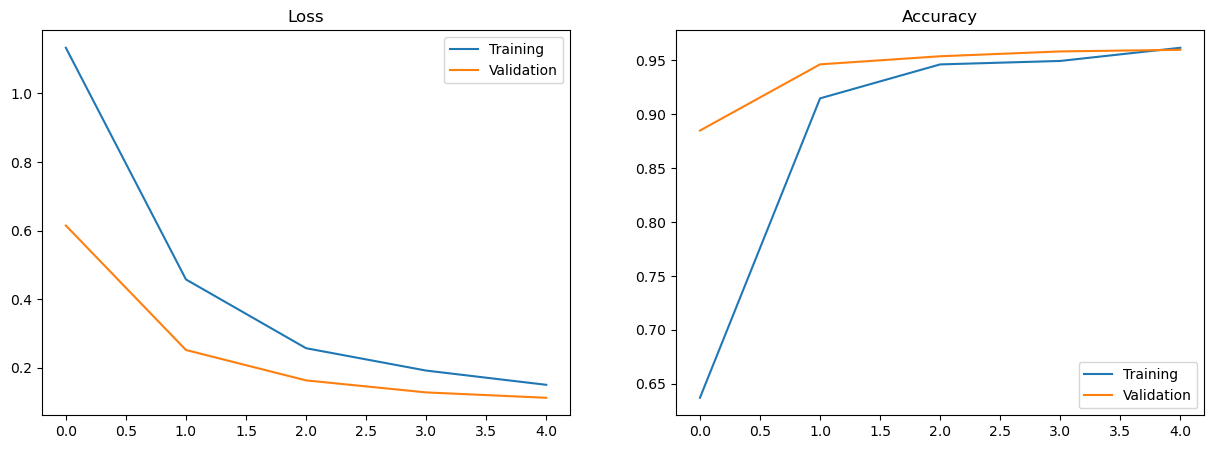

In [19]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history['train_loss'], label='Training')
ax[0].plot(history['valid_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history['train_accuracy'], label='Training')
ax[1].plot(history['valid_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [20]:
accuracy_pt = history['valid_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history['train_accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history['valid_accuracy'][-1]))
print('Training time: {:.1f}s (or {:.1f} minutes)'.format(training_time_pt, training_time_pt/60))

Accuracy Training data: 96.1%
Accuracy Test data: 96.0%
Training time: 9043.7s (or 150.7 minutes)


A acurácia parece boa (>95%)! Também observamos que a acurácia aumenta com as épocas, e as acurácias de treino e validação são próximas uma da outra, o que significa que parece não haver overfitting. 

Nosso modelo está treinado! Para manter este modelo, vamos salvá-lo.

### Salvando o modelo

Existem duas abordagens para salvar um modelo e abordaremos ambas nesta seção.

É possível salvar apenas os parâmetros do modelo. Então, para carregar o modelo, primeiro teremos que instanciar o modelo (o modelo DistilBertClassification) e, em seguida, carregar todos os seus parâmetros (treinados) neste modelo. Esta é uma maneira conveniente de armazenar um modelo, no entanto, só é possível se você tiver detalhes completos sobre a arquitetura do modelo original.

Uma alternativa é salvar o modelo inteiro. Ao fazer isso, é mais fácil carregar o modelo de seu local salvo. Vamos dar uma olhada nas duas abordagens.

In [21]:
# Salve apenas os parâmetros do modelo, mas não o modelo em si, e recupere-o
torch.save(model_pt.state_dict(), 'PyModel.sd')
model_reloaded = DistilBertClassification()
model_reloaded.load_state_dict(torch.load('PyModel.sd'))
model_reloaded.eval()

DistilBertClassification(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.2, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.2, inplace=False)
            (lin1): Lin

In [22]:
# Salve o modelo todo e recupere-o
torch.save(model_pt, 'PyModelComplete.pt')
model_reloaded2 = torch.load('PyModelComplete.pt')
model_reloaded2.eval()

DistilBertClassification(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.2, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.2, inplace=False)
            (lin1): Lin

# O que você viu nessa aula?

Nessa aula, apresentamos o BERT, um LLM que pode ser usado para várias tarefas em NLP. Dentre elas, apresentamos um caso para classificação de texto. 